**Decision Tree, Random Forest & AdaBoost**

**Student Name:** Prasanna Sundararajan Muthukumaran

**UTA ID:** 1001937587

In [1]:
# Importing all the necessary packages

import numpy as np
import pandas as pd
import re
import random
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from collections import Counter
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [2]:
# Loading the data

train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')
test_class = pd.read_csv('gender_submission.csv')

# Store our test passenger IDs for easy access
PassengerId = test['PassengerId']

# Showing overview of the train dataset
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
test_class.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [5]:
# Inserting 'Survived' column into the test dataset

test.insert(1, 'Survived', test_class['Survived'])
test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
# Copy original dataset in case we need it later when digging into interesting features
# WARNING: Beware of actually copying the dataframe instead of just referencing it
# "original_train = train" will create a reference to the train variable (changes in 'train' will apply to 'original_train')
original_train = train.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
full_data = [train, test]

# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

# Remove all NULLS in the Age column
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

In [7]:
# Feature selection: remove variables no longer containing relevant information
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [8]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


In [9]:
test.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,2,0,0,2,0,1,1,1
1,1,3,0,2,0,0,0,0,2,0,3
2,0,2,1,3,0,1,2,0,1,1,1
3,0,3,1,1,0,1,0,0,1,1,1
4,1,3,0,1,1,1,0,0,3,0,3


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

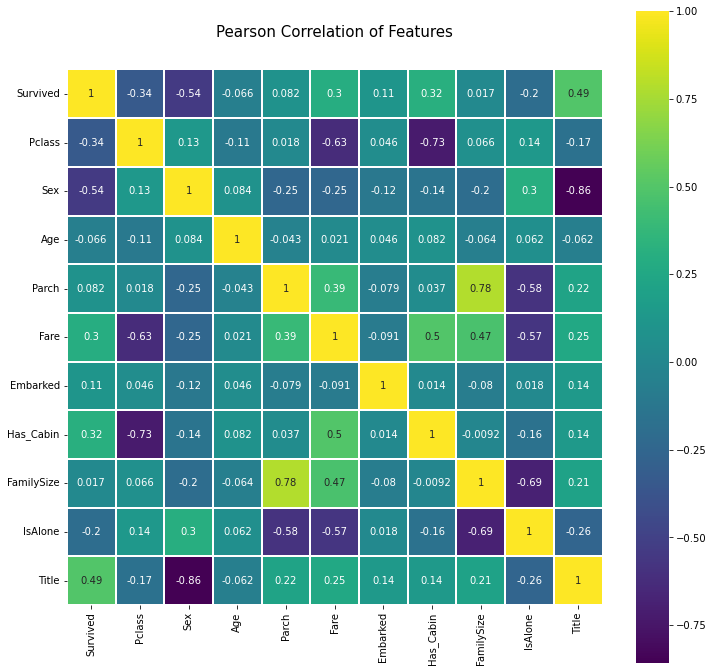

In [10]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [11]:
# Splitting the dataset into predictor and target variables

X_train = np.array(train.iloc[:, 1:]) # Predictor
X_test = np.array(test.iloc[:, 1:]) # Predictor
Y_train = np.array(train['Survived']) # Target
Y_test = np.array(test['Survived']) # Target

In [12]:
def entropy(Y):    # Y -> class labels
    count_class_labels = np.bincount(Y)
    prob_class = count_class_labels / len(Y)
    entropy = 0
    for prob in prob_class:
        if prob>0:
            entropy += -prob * np.log2(prob)
    return entropy


def gini_impurity(Y):
    count_class_labels = np.bincount(Y)
    prob_class = count_class_labels / len(Y)
    gini = 1 - np.sum(prob_class ** 2)
    return(gini)

class Node:     # Decision Nodes
    def __init__(self, feature = None, threshold = None, left_child = None, right_child = None, class_value = None):
        self.feature = feature
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child
        self.class_value = class_value    #For leaf node

    def is_leaf_node(self):
        return self.class_value is not None

class DecisionTreeClassifier:
    def __init__(self, criterion = 'entropy', max_depth = 100, min_samples_split = 2,  min_samples_leaf = 1):
        self.criterion = criterion
        self.min_samples_split = min_samples_split   # Stop splitting when n_samples < 2
        self.max_depth = max_depth    # Stop splitting at depth = 100
        self.min_samples_leaf = min_samples_leaf    #  Minimum number of samples required to be at a leaf node
        self.root = None
    
    def fit(self, X, Y):    # Generate the tree
        self.num_samples = X.shape[0]
        self.num_features = X.shape[1]
        self.root = self.generate_tree(X, Y)
        
    def predict(self, X):    # Traverse the tree
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def generate_tree(self, X, Y, depth = 0):
        # Stopping criteria
        if (depth >= self.max_depth or self.num_samples < self.min_samples_split):
            return Node(class_value = Counter(Y).most_common(1)[0][0])    # Compute leaf node's label (most common class value)

        # Selecting the features randomly
        feature_index = np.random.choice(self.num_features, self.num_features, replace=False)
        
        # Select the best split based on the information gain
        best_feature, best_threshold = self.best_split(X, Y, feature_index)
   
        # Splitting tree based on threshold value
        left_tree = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_tree = np.argwhere(X[:, best_feature] > best_threshold).flatten()

        # Growing the left and right child trees
        left_child = self.generate_tree(X[left_tree, :], Y[left_tree], depth + 1)
        right_child = self.generate_tree(X[right_tree, :], Y[right_tree], depth + 1)
        
        return Node(best_feature, best_threshold, left_child, right_child)
    
    def best_split(self, X, Y, feature_index):    # Function to find the best feature and threshold value for splitting
        split_feature_index = None
        split_threshold = None
        gain = -float('inf')
        for feature in feature_index:
            threshold_values = np.unique(X[:, feature])    # Obtaining unique threshold values
            for threshold in threshold_values:
                info_gain = self.information_gain(X[:, feature], Y, threshold)
                if info_gain > gain:
                    gain = info_gain
                    split_feature_index = feature
                    split_threshold = threshold
        return split_feature_index, split_threshold
    
    def information_gain(self, X_feature, Y, threshold):
        entropy_before_split = entropy(Y)    # Computing the entropy value before splitting into left and right subtrees
        
        #Splitting tree based on threshold value
        dataset_left = np.argwhere(X_feature <= threshold).flatten()
        dataset_right = np.argwhere(X_feature > threshold).flatten()

        if len(dataset_left) == 0 or len(dataset_right) == 0:
            return 0

        # Computing weighted average and entropy values
        num_left_sample = len(dataset_left)
        num_right_sample = len(dataset_right)
        entropy_left_sample = entropy(Y[dataset_left])
        entropy_right_sample = entropy(Y[dataset_right])
        entropy_after_split = (num_left_sample / len(Y)) * entropy_left_sample + (num_right_sample / len(Y)) * entropy_right_sample

        # Computing information gain
        info_gain = entropy_before_split - entropy_after_split
        return info_gain
    
    def traverse_tree(self, sample, node):
        if node.is_leaf_node():
            return node.class_value
        if sample[node.feature] <= node.threshold:
            return self.traverse_tree(sample, node.left_child)
        return self.traverse_tree(sample, node.right_child)

In [13]:
# Create Decision Tree with max_depth = 3
decision_tree = DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(X_train, Y_train)

# Predicting results for test dataset
Y_pred = decision_tree.predict(X_test)
print('Prediction Class:\n', Y_pred)
print('\n Actual Class:\n', Y_test)
decision_tree_accuracy = accuracy_score(Y_test, Y_pred)
print('\n Classification accuracy using decision tree:', decision_tree_accuracy * 100, '%')

Prediction Class:
 [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 0 0 0 1]

 Actual Class:
 [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0

In [14]:
class RandomForest:    # Group of decision trees
    def __init__(self, num_trees = 10, min_features = 5, criterion = None, max_depth = 100, min_samples_split = 2,  min_samples_leaf = 1):
        self.num_trees = num_trees
        self.min_features = min_features
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X, Y):
        self.trees = []
        num_features = X.shape[1]
        for i in range(self.num_trees):
            rf_tree = DecisionTreeClassifier(criterion = self.criterion, max_depth = 3, min_samples_split = self.min_samples_split,  min_samples_leaf = self.min_samples_leaf)
            if self.min_features <= num_features:
                indices = np.random.choice(num_features, random.randint(self.min_features, num_features), replace=False)
                print('Feature subset: ', indices)
                print('Subset Data: \n', X[:,indices])
                rf_tree.fit(X[:,indices], Y)
                self.trees.append(rf_tree)
                

In [15]:
random_forest = RandomForest(num_trees = 3, max_depth=10)
random_forest.fit(X_train, Y_train)

Feature subset:  [1 4 3 2 8 9 6]
Subset Data: 
 [[1 0 0 ... 0 1 0]
 [0 3 0 ... 0 3 1]
 [0 1 0 ... 1 4 0]
 ...
 [0 2 2 ... 0 4 0]
 [1 2 0 ... 1 1 1]
 [1 0 0 ... 1 1 0]]
Feature subset:  [7 9 5 2 6 1 8]
Subset Data: 
 [[2 1 0 ... 0 1 0]
 [2 3 1 ... 1 0 0]
 [1 4 0 ... 0 0 1]
 ...
 [4 4 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 2 ... 0 1 1]]
Feature subset:  [9 7 0 4 8 2 6 3 5 1]
Subset Data: 
 [[1 2 3 ... 0 0 1]
 [3 2 1 ... 0 1 0]
 [4 1 3 ... 0 0 0]
 ...
 [4 4 3 ... 2 0 0]
 [1 1 1 ... 0 1 1]
 [1 1 3 ... 0 2 1]]


**References**

[1] https://github.com/ajdillhoff/CSE6363/blob/main/decision_trees/introduction-to-decision-trees-titanic-dataset.ipynb

[2] https://anderfernandez.com/en/blog/code-decision-tree-python-from-scratch/

[3] https://betterdatascience.com/mml-decision-trees/

[4] https://towardsdatascience.com/master-machine-learning-random-forest-from-scratch-with-python-3efdd51b6d7a